In [ ]:
import numpy as np
import pandas as pd

np.random.seed(2022111937)

## 定义标准ADMM类

In [ ]:
class ADMM:
    def __init__(self, outer_params, rho=1.0, max_iter=1000, tol=1e-4):
        """
        初始化ADMM求解器
        
        参数:
        outer_params: 外层参数(sigma, X, y, lambda0, record)
        rho: 增广拉格朗日参数
        max_iter: 最大迭代次数
        tol: 收敛容差
        """
        self.sigma, self.X, self.y, self.lambda0, self.record = outer_params
        self.y = self.y.reshape(-1, 1)
        self.rho = rho
        self.max_iter = max_iter
        self.tol = tol
        
        # 初始化变量
        self.beta = None
        self.alpha = None
        self.u = None
        
        # 存储迭代过程中的残差
        self.primal_residuals = []
        self.dual_residuals = []
    
    def _fsigma(self, betai):
        """
        计算f_\sigma
        """
        if np.abs(betai) >= self.sigma:
            return 0
        elif betai > -self.sigma and betai < 0:
            return (self.sigma + betai)/(self.sigma)
        else:
            return (self.sigma - betai)/(self.sigma)
    
    def objective_func(self):
        """
        计算目标函数(带正则项)
        
        返回:
        objective_value: 目标函数值
        """
        p = self.X.shape[1]
        n = self.X.shape[0]
        F = np.vectorize(self._fsigma)
        loss = 1/n * np.linalg.norm(np.matmul(self.X, self.beta) - self.y, ord=2)**2
        penalty = self.lambda0 * (p - np.sum(F(self.beta)))
        return loss + penalty
    
    def initialize(self, beta_init, alpha_init, u_init=None):
        """
        初始化变量
        
        参数:
        beta_init: beta的初始值
        alpha_init: alpha的初始值
        u_init: u的初始值(可选)
        """
        self.beta = beta_init.reshape(-1, 1)
        self.alpha = alpha_init.reshape(-1, 1)
        if u_init is None:
            self.u = np.zeros_like(alpha_init).reshape(-1, 1)
        else:
            self.u = u_init.reshape(-1, 1)
    
    def _update_beta(self):
        """更新beta变量的步骤，需要在子类中实现"""
        n = self.X.shape[0]
        form = 2 * np.matmul(self.X.T, self.X) / n + self.rho * np.eye(self.X.shape[1])
        lat = 2 * np.matmul(self.X.T, self.y) / n - self.rho*(self.u - self.alpha)
        self.beta = np.linalg.solve(form, lat)
    
    def __update_alpha_entry(self, d):
        """更新alpha的单个元素"""
        lis = np.array([0, -(self.lambda0**2)/(2*self.rho*self.sigma)-self.lambda0*self.sigma+self.lambda0*d, (self.rho*self.sigma*d**2)/2-self.lambda0*self.sigma, -(self.lambda0**2)/(2*self.rho*self.sigma)-self.lambda0*self.sigma-self.lambda0*d])
        if np.abs(d) < self.sigma:
            lis[0] += np.inf
        if self.rho * self.sigma * d <= self.lambda0 or self.rho * self.sigma * d >= self.rho * self.sigma**2 +self.lambda0:
            lis[1] += np.inf
        if self.rho * self.sigma * d +self.lambda0+ self.rho*self.sigma**2<=0 or self.rho * self.sigma * d + self.lambda0 >=0:
            lis[3] += np.inf
        min_idx = np.argmin(lis)
        if min_idx == 0:
            x = d
        elif min_idx == 1:
            x = d - self.lambda0/(self.rho*self.sigma)
        elif min_idx == 2:
            x = 0
        else:
            x = d + self.lambda0/(self.rho*self.sigma)
        return x

    def _update_alpha(self):
        """更新alpha变量的步骤，需要在子类中实现"""
        _update_alpha_entry = np.vectorize(self.__update_alpha_entry)
        self.alpha = _update_alpha_entry(self.beta + self.u)

    
    def _update_u(self):
        """更新拉格朗日乘子u"""
        self.u = self.u + self.beta - self.alpha
    
    def _compute_residuals(self):
        """计算原始残差和对偶残差"""
        primal_residual = np.linalg.norm(self.beta - self.alpha)
        dual_residual = np.linalg.norm(-self.rho * (self.alpha - self.alpha_old))
        return primal_residual, dual_residual
    
    def _check_convergence(self, primal_residual, dual_residual):
        """检查是否收敛"""
        return primal_residual < self.tol and dual_residual < self.tol
    
    def solve(self, beta_init, alpha_init, u_init=None):
        """
        求解ADMM问题
        
        参数:
        beta_init: beta的初始值
        alpha_init: alpha的初始值
        u_init: u的初始值(可选)
        
        返回:
        beta: 最优解
        alpha: 最优解
        objective_values: 每次迭代的目标函数值
        MSE_value: 最终的MSE值
        """
        self.initialize(beta_init, alpha_init, u_init)
        
        objective_values = []

        n = self.X.shape[0]
        
        for iteration in range(self.max_iter):
            # 保存上一次的alpha值用于计算对偶残差
            self.alpha_old = self.alpha.copy()
            
            # 更新步骤
            self._update_beta()
            self._update_alpha()
            self._update_u()
            
            # 计算残差
            primal_residual, dual_residual = self._compute_residuals()
            self.primal_residuals.append(primal_residual)
            self.dual_residuals.append(dual_residual)
            
            # 计算目标函数值
            objective_value = self.objective_func()
            objective_values.append(objective_value)
            
            # 检查收敛性
            if self._check_convergence(primal_residual, dual_residual):
                if self.record:
                    print(f"Converged at iteration {iteration}")
                break
            
            # 打印进度
            if iteration < 10 and self.record:
                print(f"Iteration {iteration}, Primal Residual: {primal_residual:.6f}, Dual Residual: {dual_residual:.6f}, Objective Value: {objective_value:.6f}")
            elif iteration % 100 == 0 and self.record:
                print(f"Iteration {iteration}, Primal Residual: {primal_residual:.6f}, Dual Residual: {dual_residual:.6f}, Objective Value: {objective_value:.6f}")
        
        MSE_value = 1/n * np.linalg.norm(np.matmul(self.X, self.beta) - self.y, ord=2)**2

        return self.beta, self.alpha, objective_values, MSE_value    

<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1970622/930599922.py:28: SyntaxWarning: invalid escape sequence '\s'
  """


## 真实数据单Sigma测试（检验内层核心ADMM代码的正确性）


优化结果:
最优beta (前10个元素): [ 0.00100588 -0.06417863 -0.09614113  0.05615317 -0.06307601  0.01245956
  0.13288864  0.25529113  0.03079071  0.17644464]
二范数：10.680167370782819；一范数：116.71506704401504
最优alpha (前10个元素): [ 0.00100588 -0.06417863 -0.09614113  0.05615317 -0.06307601  0.01245956
  0.13288864  0.25529113  0.03079071  0.17644464]
最终目标函数值: 0.123755


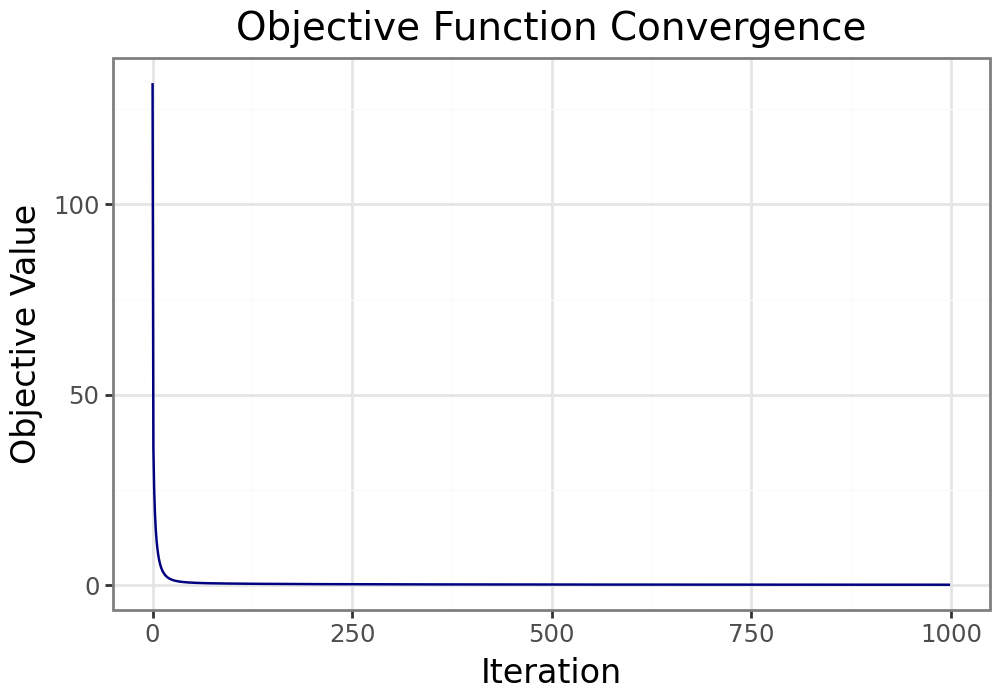

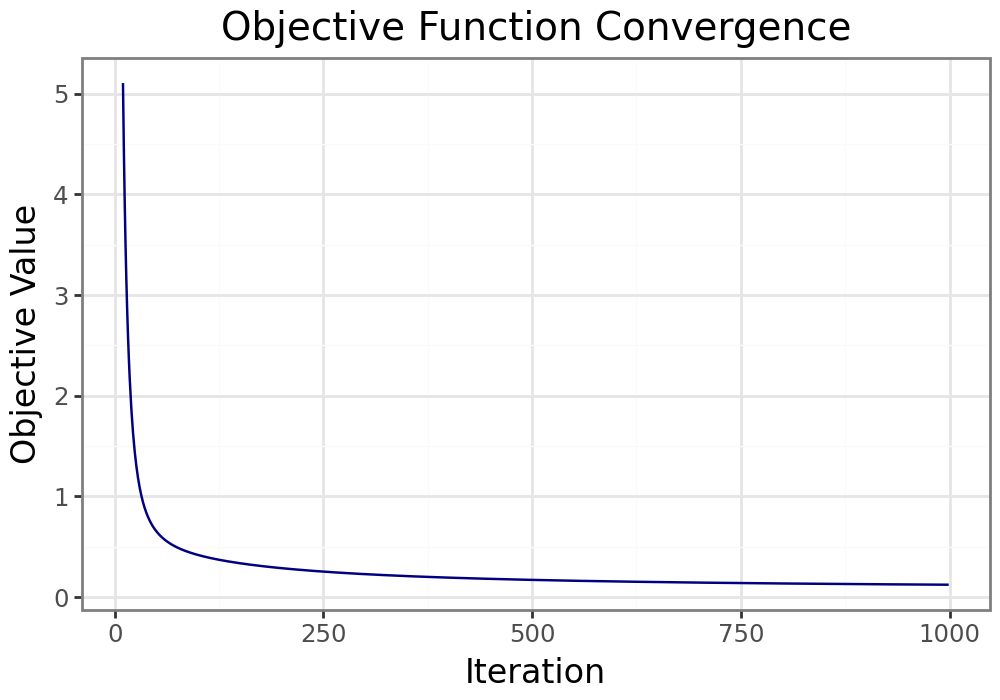

/home/test2/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


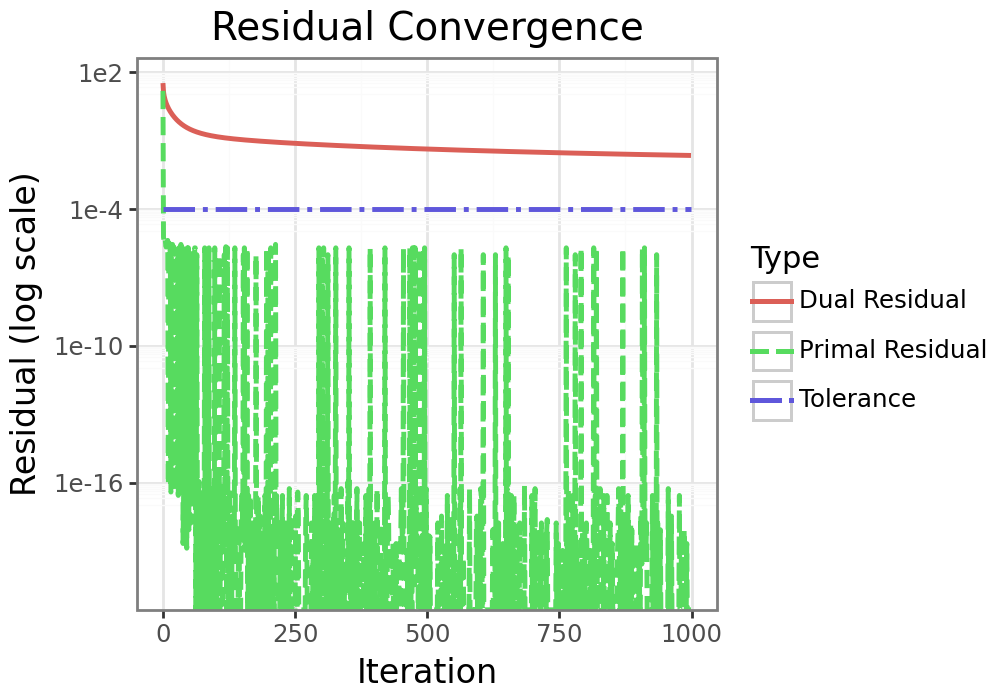

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_line, geom_hline, labs, scale_y_log10, theme_bw, theme, element_text

data = pd.read_csv("train.csv")
X = data.iloc[:, :-1].values  
y = data.iloc[:, -1].values  
y = (y - y.mean())/y.std()
n_samples, n_features = X.shape

p = n_features
mu, sigma = 0, 1
beta_init = np.random.normal(mu, sigma, (p, 1))
alpha_init = np.random.normal(mu, sigma, (p, 1))
u_init = np.random.normal(mu, sigma, (p, 1))

sigma0 = 1.0
lambda0 = 1e-5
record = False
outer_params = (sigma0, X, y, lambda0, record)
admm = ADMM(outer_params, rho=10.0, max_iter=1000, tol=1e-4)

beta_opt, alpha_opt, objective_values, mse_values = admm.solve(beta_init, alpha_init, u_init)

print("\n优化结果:")
print(f"最优beta (前10个元素): {beta_opt[:10].flatten()}")
print(f"二范数：{np.linalg.norm(beta_opt.reshape(-1))}；一范数：{np.linalg.norm(beta_opt.reshape(-1), ord=1)}")
print(f"最优alpha (前10个元素): {alpha_opt[:10].flatten()}")
print(f"最终目标函数值: {objective_values[-1]:.6f}")

# 下面绘制损失函数和原始、对偶残差图
df_obj = pd.DataFrame({'Iteration': np.arange(len(objective_values)), 'Objective': objective_values})

plot1 = (
    ggplot(df_obj, aes(x='Iteration', y='Objective')) +
    geom_line(color="navy") +
    theme_bw() +
    labs(title='Objective Function Convergence', x='Iteration', y='Objective Value') +
    theme(
        figure_size=(5, 3.5),
        plot_title=element_text(size=14, family="sans-serif"),
        axis_title=element_text(size=12, family="sans-serif"),
        axis_text=element_text(family="sans-serif")
    )
)
display(plot1)

plot1_ = (
    ggplot(df_obj[10:], aes(x='Iteration', y='Objective')) +
    geom_line(color="navy") +
    theme_bw() +
    labs(title='Objective Function Convergence', x='Iteration', y='Objective Value') +
    theme(
        figure_size=(5, 3.5),
        plot_title=element_text(size=14, family="sans-serif"),
        axis_title=element_text(size=12, family="sans-serif"),
        axis_text=element_text(family="sans-serif")
    )
)
display(plot1_)

df_res = pd.DataFrame({
    'Iteration': np.concatenate([
        np.arange(len(admm.primal_residuals)),
        np.arange(len(admm.dual_residuals)),
        np.arange(len(admm.primal_residuals))
    ]),
    'Residual': np.concatenate([
        admm.primal_residuals,
        admm.dual_residuals,
        np.full_like(admm.primal_residuals, admm.tol)
    ]),
    'Type': (["Primal Residual"] * len(admm.primal_residuals)) +
            (["Dual Residual"] * len(admm.dual_residuals)) +
            (["Tolerance"] * len(admm.primal_residuals))
})

plot2 = (
    ggplot(df_res, aes(x='Iteration', y='Residual', color='Type', linetype='Type')) +
    geom_line(size=1.0) +
    scale_y_log10() +
    theme_bw() +
    labs(title='Residual Convergence', x='Iteration', y='Residual (log scale)') +
    theme(
        figure_size=(5, 3.5),
        legend_title=element_text(family="sans-serif"),
        plot_title=element_text(size=14, family="sans-serif"),
        axis_title=element_text(size=12, family="sans-serif"),
        axis_text=element_text(family="sans-serif")
    )
)
display(plot2)


## 定义外层大类

In [4]:
class ADMM_Outer:
    def __init__(self, env_params, record = False):
        """
        外层ADMM算法
        
        参数:
        env_params: 环境参数，包括特征矩阵X、标签向量y、正则化参数lambda0、步长c、最大迭代次数J_Max
        record: 是否记录迭代过程
        
        """
        self.X, self.y, self.X_test, self.y_test, self.lambda0, self.c, self.J_Max = env_params
        self.n, self.p = self.X.shape
        self.record = record
        self.sigma = None

    def _fit_Ridge(self):
        """
        使用岭回归拟合beta，以便于获取sigma初值
        
        返回:
        beta: 拟合的beta
        """
        self.beta = np.linalg.solve(np.matmul(self.X.T, self.X)+self.lambda0*np.eye(X.shape[1]), np.matmul(self.X.T, self.y))
        return self.beta
    
    def _initialize_sigma(self):
        """
        初始化sigma
        
        返回:
        sigma: 初始化的sigma
        """
        LSE_beta = self._fit_Ridge()
        self.sigma = 3 * np.linalg.norm(LSE_beta, ord=np.inf)
    
    def solve(self):
        """
        求解ADMM问题
        
        返回:
        beta: 最优解
        alpha: 最优解
        objective_values: 每次迭代的目标函数值
        sigma: 最终的sigma
        MSE_value: 最终的MSE值
        """
        self._initialize_sigma()
        self.alpha = np.zeros_like(self.beta)
        max_iter = 1000
        for J in range(self.J_Max):
            if J == self.J_Max - 1:
                max_iter = 5000
            outer_params = (self.sigma, self.X, self.y, self.lambda0, self.record)
            admm = ADMM(outer_params, rho=1.0, max_iter=max_iter, tol=1e-4)
            self.beta, self.alpha, self.objective_values, MSE_value = admm.solve(self.beta, self.alpha)

            y_pred_test = self.X_test.dot(self.beta)
            mse_test    = np.mean((self.y_test - y_pred_test) ** 2)

            if self.record:
                print(f"外层第 {J} 轮已执行完, L1:{np.linalg.norm(self.beta, ord=1)}, L2:{np.linalg.norm(self.beta, ord=2)}, Train MSE: {MSE_value:.6f}, Test MSE: {mse_test:.6f}, sigma: {self.sigma:.6f}\n")

            self.sigma = self.sigma * self.c
        return self.beta, self.alpha, self.objective_values, self.sigma, MSE_value
        


## 外层真实数据测试（检验加入外层大循环后代码的正确性）

In [ ]:
data = pd.read_csv("train.csv")
X = data.iloc[:, :-1].values  # 特征
y = data.iloc[:, -1].values.reshape(-1, 1)  
n_samples, n_features = X.shape

y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std

data_test = pd.read_csv("test.csv")
X_test = data_test.iloc[:, :-1].values 
y_test = data_test.iloc[:, -1].values.reshape(-1, 1)  

y_test_zscore = (y_test - y_mean) / y_std
y_test = y_test_zscore

p = n_features
lambda0 = 1e-5
c = 0.5
J_Max  =10
env_params = (X, y, X_test, y_test, lambda0, c, J_Max)
Solver = ADMM_Outer(env_params, record = True)

beta_opt, alpha_opt, objective_values, final_sigma, final_MSE = Solver.solve()

print("\n优化结果:")
print(f"最优beta (前10个元素): {beta_opt[:10].flatten()}")
print(f"二范数：{np.linalg.norm(beta_opt.reshape(-1))}；一范数：{np.linalg.norm(beta_opt.reshape(-1), ord=1)}")
print(f"最终目标函数值: {objective_values[-1]:.6f}")
print(f"最终sigma: {final_sigma:.6f}")
print(f"最终MSE: {final_MSE:.6f}")




Iteration 0, Primal Residual: 0.000001, Dual Residual: 0.286088, Objective Value: 0.118617
Iteration 1, Primal Residual: 0.000000, Dual Residual: 0.089059, Objective Value: 0.105980
Iteration 2, Primal Residual: 0.000000, Dual Residual: 0.056090, Objective Value: 0.102080
Iteration 3, Primal Residual: 0.000000, Dual Residual: 0.043488, Objective Value: 0.099958
Iteration 4, Primal Residual: 0.000000, Dual Residual: 0.037404, Objective Value: 0.098459
Iteration 5, Primal Residual: 0.000000, Dual Residual: 0.033780, Objective Value: 0.097262
Iteration 6, Primal Residual: 0.000000, Dual Residual: 0.031234, Objective Value: 0.096248
Iteration 7, Primal Residual: 0.000000, Dual Residual: 0.029241, Objective Value: 0.095365
Iteration 8, Primal Residual: 0.000000, Dual Residual: 0.027578, Objective Value: 0.094582
Iteration 9, Primal Residual: 0.000000, Dual Residual: 0.026138, Objective Value: 0.093881
Iteration 100, Primal Residual: 0.000000, Dual Residual: 0.007023, Objective Value: 0.0807

## 真实数据并行调参

In [ ]:
import ray

data = pd.read_csv("train.csv")
X = data.iloc[:, :-1].values 
y = data.iloc[:, -1].values.reshape(-1, 1)   
n_samples, n_features = X.shape

y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std

data_test = pd.read_csv("test.csv")
X_test = data_test.iloc[:, :-1].values
y_test = data_test.iloc[:, -1].values.reshape(-1, 1)   # 标签

y_test_zscore = (y_test - y_mean) / y_std
y_test = y_test_zscore

p = n_features
lambda_candidates = [1e-7, 5e-7, 1e-6, 5e-6, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01]
c = 0.5
J_Max = 10


ray.shutdown() 
ray.init(log_to_driver = False)

# 使用ray并行来调参
@ray.remote
def parallel_solver(lab, X, y, X_test, y_test, c, J_Max):
    env_params = (X, y, X_test, y_test, lab, c, J_Max)
    Solver = ADMM_Outer(env_params, record=False)
    beta_opt, alpha_opt, objective_values, final_sigma, final_MSE = Solver.solve()

    test_mse = np.mean((X_test.dot(beta_opt) - y_test) ** 2)

    return {
        "lab": lab,
        "beta_opt": beta_opt,
        "objective_values": objective_values,
        "final_sigma": final_sigma,
        "final_MSE": final_MSE,
        "test_mse": test_mse,
    }

futures = [
    parallel_solver.remote(lab, X, y, X_test, y_test, c, J_Max)
    for lab in lambda_candidates
]

results = ray.get(futures)

for res in results:
    print(f"\n lambda0={res['lab']}时的优化结果优化结果:")
    print(f"最优beta (前10个元素): {res['beta_opt'][:10].flatten()}")
    print(f"二范数：{np.linalg.norm(res['beta_opt'].reshape(-1))}；一范数：{np.linalg.norm(res['beta_opt'].reshape(-1), ord=1)}")
    print(f"最终目标函数值: {res['objective_values'][-1]:.6f}")
    print(f"最终sigma: {res['final_sigma']:.6f}")
    print(f"最终MSE: {res['final_MSE']:.6f}")
    print(f"测试MSE: {res['test_mse']:.6f}")

# 用完关闭 Ray
ray.shutdown()


2025-06-12 06:14:56,640	INFO worker.py:1841 -- Started a local Ray instance.



 lambda0=1e-07时的优化结果优化结果:
最优beta (前10个元素): [ 4.64031565e-02 -7.43436613e-02 -2.14076668e-04  4.96385005e-02
  3.13433814e-01  3.18756955e-02  1.85301012e-01 -6.14461142e-02
  1.97372955e-02  6.29914261e-01]
二范数：13.477330462917003；一范数：55.2670860314028
最终目标函数值: 0.059807
最终sigma: 0.889917
最终MSE: 0.059805
测试MSE: 0.118344

 lambda0=5e-07时的优化结果优化结果:
最优beta (前10个元素): [ 4.63913283e-02 -7.42627695e-02 -2.08749337e-04  4.96418825e-02
  3.13409893e-01  3.18803199e-02  1.85214107e-01 -6.14309248e-02
  1.97374841e-02  6.28322774e-01]
二范数：13.475614790170491；一范数：55.17788444967663
最终目标函数值: 0.059818
最终sigma: 0.788786
最终MSE: 0.059805
测试MSE: 0.118341

 lambda0=1e-06时的优化结果优化结果:
最优beta (前10个元素): [ 4.63731244e-02 -7.41392248e-02 -2.00583876e-04  4.96471222e-02
  3.13372784e-01  3.18871482e-02  1.85081125e-01 -6.14079405e-02
  1.97376997e-02  6.25890165e-01]
二范数：13.473033502364238；一范数：55.04162309146541
最终目标函数值: 0.059835
最终sigma: 0.698758
最终MSE: 0.059807
测试MSE: 0.118337

 lambda0=5e-06时的优化结果优化结果:
最优beta (前10

## 对X通过Bootstrap获得置信区间

In [8]:
import ray

data = pd.read_csv("train.csv")
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values.reshape(-1, 1)  # Labels
n_samples, n_features = X.shape

y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std

lambda0 = 1e-5
c = 0.5
J_Max = 10
n_bootstraps = 500

if ray.is_initialized():
    ray.shutdown()
ray.init(log_to_driver = False) 

X_ref = ray.put(X)
y_ref = ray.put(y)

# Bootstrap天然适合并行加速，使用ray框架并行
@ray.remote
def bootstrap_worker(X_full, y_full, lambda0, c, J_Max, n_samples):
    bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
    X_boot = X_full[bootstrap_indices]
    y_boot = y_full[bootstrap_indices]

    env_params = (X_boot, y_boot, X_boot, y_boot, lambda0, c, J_Max)
    solver = ADMM_Outer(env_params, record=False)
    
    beta_opt, _, _, _, _ = solver.solve()
    
    return beta_opt.flatten()

futures = [
    bootstrap_worker.remote(X_ref, y_ref, lambda0, c, J_Max, n_samples)
    for _ in range(n_bootstraps)
]

bootstrap_betas = ray.get(futures)

ray.shutdown()

betas_matrix = np.array(bootstrap_betas)

lower_bounds = np.percentile(betas_matrix, 2.5, axis=0)
upper_bounds = np.percentile(betas_matrix, 97.5, axis=0)

print(f"Bootstrapping complete ({n_bootstraps} iterations) with lambda0 = {lambda0}\n")
print("95% Confidence Intervals for Beta Coefficients:")
print("-" * 50)
for i in range(n_features):
    print(f"  Beta_{i:<4}: ({lower_bounds[i]:.6f}, {upper_bounds[i]:.6f})")
print("-" * 50)

2025-06-12 06:19:06,112	INFO worker.py:1841 -- Started a local Ray instance.


Bootstrapping complete (500 iterations) with lambda0 = 1e-05

95% Confidence Intervals for Beta Coefficients:
--------------------------------------------------
  Beta_0   : (0.011324, 0.083679)
  Beta_1   : (-0.152874, 0.008535)
  Beta_2   : (-0.035125, 0.042044)
  Beta_3   : (0.013233, 0.100648)
  Beta_4   : (0.208541, 0.431869)
  Beta_5   : (-0.023238, 0.070891)
  Beta_6   : (0.073799, 0.257853)
  Beta_7   : (-0.122728, 0.011954)
  Beta_8   : (-0.045660, 0.095701)
  Beta_9   : (0.109397, 1.113069)
  Beta_10  : (-0.004743, 0.366922)
  Beta_11  : (-0.049977, 0.901791)
  Beta_12  : (-0.684920, 0.296297)
  Beta_13  : (-0.000000, 0.181007)
  Beta_14  : (0.107634, 0.391126)
  Beta_15  : (-0.042356, 0.022638)
  Beta_16  : (0.255951, 0.475462)
  Beta_17  : (-0.136127, 0.153560)
  Beta_18  : (-0.599940, 0.975413)
  Beta_19  : (-0.006553, 0.289934)
  Beta_20  : (-0.457731, 0.001909)
  Beta_21  : (-0.160617, -0.022048)
  Beta_22  : (-0.145355, 0.068344)
  Beta_23  : (-0.127302, 0.057577)
  Bet

In [9]:
lower_bounds = np.percentile(betas_matrix, 5.0, axis=0)
upper_bounds = np.percentile(betas_matrix, 95.0, axis=0)

print(f"Bootstrapping complete ({n_bootstraps} iterations) with lambda0 = {lambda0}\n")
print("90% Confidence Intervals for Beta Coefficients:")
print("-" * 50)
for i in range(n_features):
    print(f"  Beta_{i:<4}: ({lower_bounds[i]:.6f}, {upper_bounds[i]:.6f})")
print("-" * 50)

Bootstrapping complete (500 iterations) with lambda0 = 1e-05

90% Confidence Intervals for Beta Coefficients:
--------------------------------------------------
  Beta_0   : (0.016961, 0.075576)
  Beta_1   : (-0.136338, -0.004554)
  Beta_2   : (-0.030554, 0.036219)
  Beta_3   : (0.018368, 0.088795)
  Beta_4   : (0.230088, 0.417534)
  Beta_5   : (-0.013569, 0.064849)
  Beta_6   : (0.084214, 0.247167)
  Beta_7   : (-0.115929, 0.000828)
  Beta_8   : (-0.035997, 0.078737)
  Beta_9   : (0.138626, 1.033919)
  Beta_10  : (0.000121, 0.333317)
  Beta_11  : (-0.028087, 0.774822)
  Beta_12  : (-0.568895, 0.273135)
  Beta_13  : (-0.000000, 0.164042)
  Beta_14  : (0.126281, 0.359749)
  Beta_15  : (-0.035319, 0.017980)
  Beta_16  : (0.272564, 0.460475)
  Beta_17  : (-0.097834, 0.133879)
  Beta_18  : (-0.495130, 0.360851)
  Beta_19  : (0.004448, 0.247904)
  Beta_20  : (-0.395926, -0.024070)
  Beta_21  : (-0.150842, -0.033698)
  Beta_22  : (-0.130460, 0.058173)
  Beta_23  : (-0.109403, 0.037964)
  Bet